In [6]:
import pandas as pd
import re
from textblob import TextBlob
from collections import Counter
import os
import matplotlib.pyplot as plt

# === Define your folder and files ===
folder = "Whatsapp_Data"
files = [
    "WhatsApp_DAO_Core_Team.txt",
    "WhatsApp_TDN_CONTENT_CREATION_TEAM.txt",
    "WhatsApp_TDN_Events.txt",
    "WhatsApp_TDN_GENERAL.txt",
    "WhatsApp_TDN_GRAPHICS_COLLABORATION_HUB.txt",
    "WhatsApp_TDN_Job_Board.txt",
    "WhatsApp_TDN_Product_DEV_team.txt",
    "WhatsApp_TDN_Resources.txt",
    "WhatsApp_TDN_Web3_Alphas.txt"
]

# === Function to process each file ===
def process_chat_file(file_path, group_name):
    with open(file_path, "r", encoding="utf-8") as file:
        lines = [line.strip() for line in file if line.strip()]
    
    data = []
    for line in lines:
        parts = [p.strip() for p in line.split(";")]
        if len(parts) >= 5:
            date = parts[0]
            hour = parts[1]
            minute = parts[2]
            sender = parts[3]
            message = ";".join(parts[4:])
            data.append([date, hour, minute, sender, message, group_name])
    
    return pd.DataFrame(data, columns=["Date", "Hour", "Minute", "Sender", "Message", "Group"])

# === Process all files ===
all_dfs = []

for filename in files:
    full_path = os.path.join(folder, filename)
    group_name = filename.replace(".txt", "").replace("WhatsApp_", "").replace("_", " ")
    df = process_chat_file(full_path, group_name)
    all_dfs.append(df)

# === Combine everything ===
df_combined = pd.concat(all_dfs, ignore_index=True)

# === Clean and format ===
df_combined["Time"] = df_combined["Hour"].str.zfill(2) + ":" + df_combined["Minute"].str.zfill(2)
df_combined.drop(["Hour", "Minute"], axis=1, inplace=True)
df_combined["Date"] = pd.to_datetime(df_combined["Date"], dayfirst=True, errors="coerce")
df_combined["Time"] = pd.to_datetime(df_combined["Time"], format="%H:%M", errors="coerce").dt.time
df_combined.dropna(subset=["Date", "Time", "Sender", "Message"], inplace=True)

# === Add Sentiment Columns ===
df_combined["Polarity"] = df_combined["Message"].apply(lambda msg: TextBlob(str(msg)).sentiment.polarity)
df_combined["Sentiment"] = df_combined["Polarity"].apply(
    lambda p: "Positive" if p > 0.2 else "Negative" if p < -0.2 else "Neutral"
)

# === Calculate TimesMentioned column ===
unique_senders = df_combined['Sender'].unique()
mention_counts = {sender: 0 for sender in unique_senders}

for index, row in df_combined.iterrows():
    message = str(row['Message'])
    sender = row['Sender']
    
    for target in unique_senders:
        if target != sender:
            pattern = fr'@{re.escape(target)}\b'
            matches = re.findall(pattern, message, flags=re.IGNORECASE)
            mention_counts[target] += len(matches)

df_combined['TimesMentioned'] = df_combined['Sender'].map(mention_counts)

# === Save to Excel ===
df_combined.to_excel("All_WhatsApp_Groups_Combined.xlsx", index=False)
print("✅ Combined dataset saved as 'All_WhatsApp_Groups_Combined.xlsx'")




✅ Combined dataset saved as 'All_WhatsApp_Groups_Combined.xlsx'


In [7]:
df_dao = df_combined

df_dao.head()

,Date,Sender,Message,Group,Time,Polarity,Sentiment,TimesMentioned
0,2024-10-15,Messages and calls are end,to;end encrypted. Only people in this chat can...,DAO Core Team,20:45:00,0.25,Positive,0
1,2024-10-15,Violet Benson added you to a group in the comm...,THE DAO NETWORK Community Announcement,DAO Core Team,20:45:00,0.00,Neutral,0
2,2024-10-17,Jesus Is Lord,GM GM Core team,DAO Core Team,09:18:00,0.00,Neutral,0
3,2024-10-17,Jesus Is Lord,If there are any questions;you can ask here or...,DAO Core Team,09:18:00,0.00,Neutral,0
4,2024-10-17,Jesus Is Lord,Then for the product team,DAO Core Team,09:19:00,0.00,Neutral,0


# Visualizations

- Sentiment Analysis

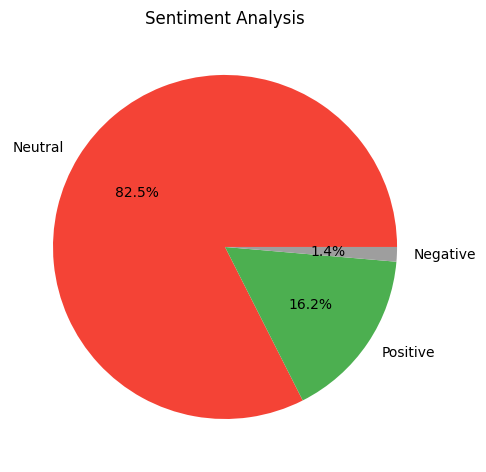

In [11]:
sentiment_counts = df_dao["Sentiment"].value_counts()
plt.figure(figsize=(5,5))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['#F44336', '#4CAF50', '#9E9E9E'])
plt.title("Sentiment Analysis")
plt.tight_layout()
plt.savefig("Images/sentiment_analysis_donut.png")
plt.show()


- Total Message by Year

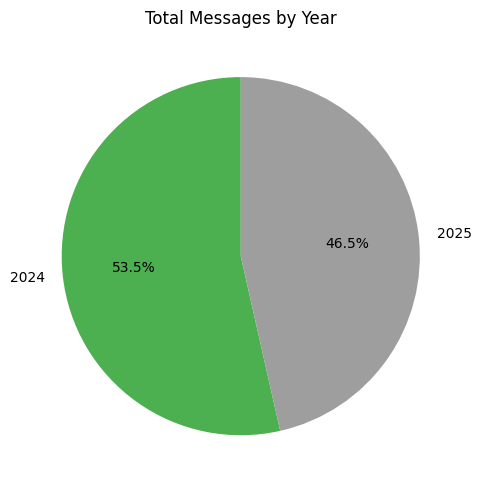

In [12]:
df_dao["Year"] = df_dao["Date"].dt.year
yearly_counts = df_dao.groupby("Year").size()
yearly_counts.plot(kind="pie", autopct='%1.1f%%', startangle=90, figsize=(5,5), colors=['#4CAF50', '#9E9E9E'])
plt.ylabel("")
plt.title("Total Messages by Year")
plt.tight_layout()
plt.savefig("Images/total_messages_by_year.png")
plt.show()


- Daily Message Volume

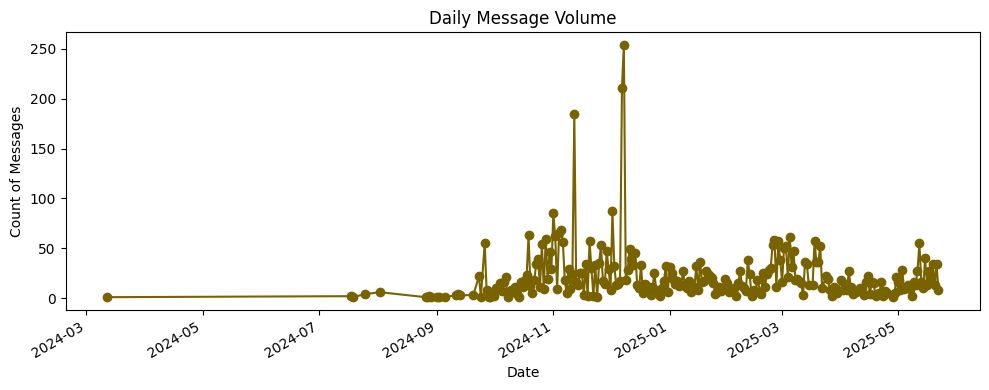

In [14]:
daily_volume = df_dao.groupby("Date").size()
plt.figure(figsize=(10,4))
daily_volume.plot(marker='o', color="#796200")  # olive tone to match Power BI
plt.title("Daily Message Volume")
plt.xlabel("Date")
plt.ylabel("Count of Messages")
plt.tight_layout()
plt.savefig("Images/daily_volume.png")
plt.show()

- Top Senders

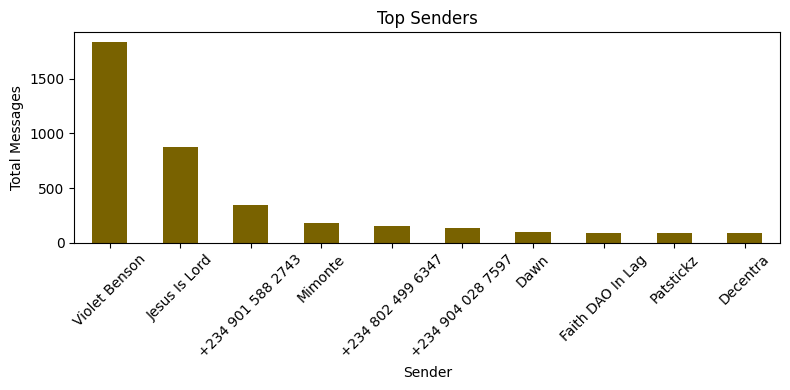

In [15]:
top_senders = df_dao["Sender"].value_counts().head(10)
plt.figure(figsize=(8,4))
top_senders.plot(kind="bar", color="#796200")
plt.title("Top Senders")
plt.xlabel("Sender")
plt.ylabel("Total Messages")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Images/top_senders_python.png")
plt.show()


-  Total Message by Group

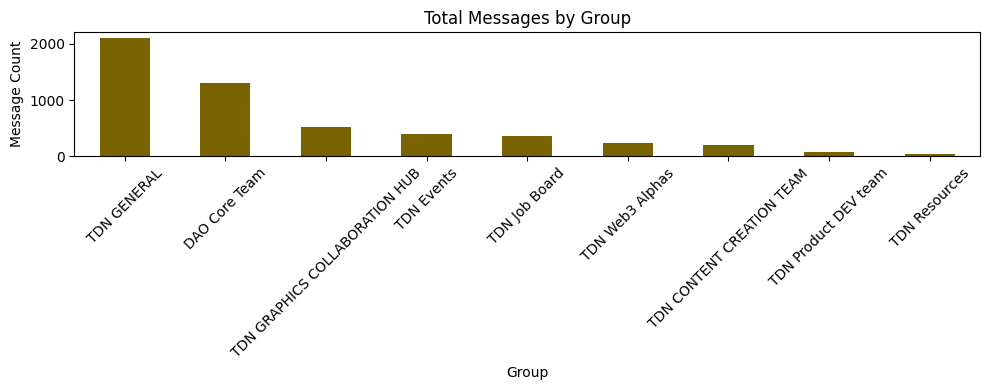

In [20]:
# Assumes `Group` column is present (merged across multiple txts)
group_count = df_dao["Group"].value_counts()
plt.figure(figsize=(10,4))
group_count.plot(kind="bar", color="#796200")
plt.title("Total Messages by Group")
plt.xlabel("Group")
plt.ylabel("Message Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Images/messages_by_group.png")
plt.show()
